# Notebook proyecto de memoria
## Estudio de algoritmos de regresión multi-salida aplicados en la predicción de eficiencia de microrredes eléctricas.
Por Sebastián Cancino.
## Dataset Alemana

Este Notebook contiene el código usado para ejecutar las actividades del estudio. Esto conlleva la carga de datos, la limpieza de datos nulos, análisis estadístico, entrenamiento y optimización de modelos predictivos, visualización y evaluación de resultados obtenidos y evaluación de interpretación de modelos.

Este Notebook se limita a llevar a cabo las actividades. Para discución sobre los resultados obtenidos, o conclusiones respecto a las tareas ejecutadas se recomienda consultar la memoria que acompaña este proyecto.

## Imports

In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import time
import json
import os

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV, RepeatedKFold
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.multioutput import RegressorChain
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from IPython.display import display
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.4f}'.format

In [2]:
# Para propositos de depuración, revisar versión de sklearn
# Este notebook fue originalmente ejecutado con versión 1.0.2
from sklearn import __version__
__version__

'1.0.2'

In [3]:
# Para propósitos de depuración, ver directorio de trabajo
# El notebook asume que el repositorio ha sido clonado en el directorio de trabajo del servidor jupyter
# Manteniendo los nombres
os.getcwd()

'C:\\Users\\sebca'

## Variables de Control

Las siguientes variables de control alteran el comportamiento del Notebook. A continuación, se detalla su utilidad:  

* NOTEBOOK_FOLDER_PATH: Esta variable de control es usada para indicar la ubicación del directorio de este notebook, para poder hacer los paths a los distintos paths requeridos para leer o guardar datos desde disco. Se recomienda que esta variable tenga el path relativo del directorio donde se encuentra este notebook respecto al directorio de trabajo del servidor Jupyter. El valor predeterminado asume que el reposiorio de este proyecto ha sido clonado en el directorio de trabajo del servidor Jupyter.
* CSV_DATA_FILEPATH: Esta variable controla la ubicación del dataset en formato csv a cargar. Se recomienda mantener el valor predeterminado, y sólo cambiarlo cuando el nombre del fichero csv a cargar ha cambiado. 
* HYPERPARAMETERS_CONFIG_FILEPATH: Esta variable controla la ubicacion del archivo de configuración para hiperparámetros óptimos. Este path se usa tanto para cargar como para guardar la configuración de hiperparámetros, así que se recomienda mantener el valor predeterminado. 
* SHOULD_SAMPLE: Variable que controla si se debe tomar un fragmento del dataset. Su valor por defecto es False, lo que indica que debe usar el dataset completo. Con el valor True, usará solo un porcentaje del dataset, el que se indica en SAMPLE_PER.
* SAMPLE_PER: Cuando SHOULD_SAMPLE es True, este valor representa la fracción del total del dataset a usar. Este valor debe ser mayor a 0 y igual o menor que 1, siendo 1 el total del dataset, 0.5 la mitad, etc.
* DATASET_NAME: Variable que controla el nombre del dataset. Este controla distintos elementos del funcionamiento del Notebook, y se recomienda no ser cambiado. Es usado para cargar el dataset, para la generación de gráficos y almacenamiento de datos.
* TRAIN_MODELS: Variable que controla el entrenamiento de modelos. Si este valor es True, entonces entrenará los modelos con el dataset indicado. Si es falso, se omite el entrenamineto de estos y de las demás actividades que requieran los modelos entrenados. Estos modelos son entrenados con hiperparámetros predeterminados. 
* N_FOLDS: Cantidad de folds a usar durante la validación cruzada en entrenamiento de modelos. Su valor por defecto es 10.
* RAND_STATE: Valor semilla a usar en métodos que requieran números aleatorios. Su función es hacer los resultados obtenidos en la ejecución sean reproducibles. El valor por defecto es 42, un número arbitrario elegido por ser la respuesta a la vida, el universo y todo lo demás.
* REMOVE_COLUMNS: Una de las actividades realizadas en el notebook es el descarte de las columnas en donde la varianza es cero, para disminuir la complejidad del dataset sin alterar los resultados obtenidos. El valor por defecto es True, y no debería ser alterado.
* TEST_SIZE: Controla el tamaño del dataset de prueba con el que se evaluarán los modelos entrenados. El complemento de este valor corresponde al tamaño del dataset de entrenamineto, por lo que su valor no debería ser mayor a 0.3, y menor a 0.1
* GRIDSEARCH: Variable que controla la ejecución de búsqueda de hiperparámetros optimos para los algoritmos. Debido a su alta complejidad de ejecución, se recomienda omitir esta actividad, siendo este el comportamiento por defecto. True ejecuta la búsqueda, false lo omite.
* N_REPEATS: Esta variable controla la canitdad de repeticiones de validación cruzada al momento de ejecutar la búqueda de hiperparámetros. Su valor debe ser un entero mayor o igual a 1, y su valor predeterminado es 3. Para valores a usar en esta variable, se recomienda buscar en la literatura valores recomendados para repeated k-fold cv.

In [4]:
# Este valor debe ser un string
NOTEBOOK_FOLDER_PATH = './proyecto-memoria'

# Este valor debe ser un string.
CSV_DATA_FILEPATH = NOTEBOOK_FOLDER_PATH + '/data_process/Alemana.csv'

# Este valor debe ser un string.
HYPERPARAMETERS_CONFIG_FILEPATH = NOTEBOOK_FOLDER_PATH + '/json/Alemana_hyp_config.json'

# Este valor debe ser un booleano.
SHOULD_SAMPLE = True

# Este valor debe ser un número pertenieciente a ]0, 1]
SAMPLE_PER = 0.1

# Este valor debe ser un string.
DATASET_NAME = 'Alemana'

# Este valor debe ser un booleano.
TRAIN_MODELS = True

# Este valor debe ser un entero positivo. 
# Se recomienda consultar literatura sobre k-fold cv para valores recomendados.
N_FOLDS = 10

# Este valor debe ser un numero entero.
RAND_STATE = 42

# Este valor debe ser un número perteneciente a ]0, 1]
# Se recomiendan valores entre [0.1, 0.3]
TEST_SIZE = 0.2

# Este valor debe ser un booleano.
REMOVE_COLUMNS = True

# Este valor debe ser un booleano.
GRIDSEARCH = False

# Este valor debe ser un entero mayor o igual a 1.
# Se recomienda consultar literatura sobre repeated k-fold para valores recomendados.
N_REPEATS = 3

### Modelos

Se definen los algoritmos con los que se entrenarán los modelos. Estos se definen en dentro de un diccionario, con el fin de simplificar la ejecución de actividades más adelante.

In [5]:
estimators = {'SGD': RegressorChain(base_estimator=SGDRegressor(max_iter=1000, tol=1e-3, random_state=RAND_STATE), random_state=RAND_STATE),
              'Linear': RegressorChain(base_estimator=LinearRegression(), random_state=RAND_STATE),
              'SVR': RegressorChain(base_estimator=SVR(), random_state=RAND_STATE),
              'RandomForest': RandomForestRegressor(random_state=RAND_STATE),
              'GradientBoosting': RegressorChain(base_estimator=GradientBoostingRegressor(random_state=RAND_STATE), random_state=RAND_STATE),
              'MLP': MLPRegressor(random_state=RAND_STATE)}

## Carga de datos

Se cargan los datos desde el disco. Este dataset debe encontrarse en formato csv, en el el directorio esperado. El dataset debe encontrarse dentro de un directorio "data", en el ambiente de ejecución. Se muestra la cabecera del dataset, con el fin de verificar su correcta carga.

In [6]:
# El dataset esperado incluye en la primera columna el valor de indice,
# por lo que al momento de cargar el dataset se debe indicar que 
# la columna 0 corresponde al índice. (index_col=0)
df = pd.read_csv(CSV_DATA_FILEPATH, index_col=0)
df.head().T

C:\Users\sebca\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (3,6,9,25,29,35,36,40,41) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,0,1,2,3,4
Load Farm pini,0.0000,0.0000,0.0000,0.0000,0.0000
Load Farm voltage,1.0005,1.0005,1.0005,1.0005,1.0005
Load Farm terminal,BB Farm,BB Farm,BB Farm,BB Farm,BB Farm
Load Industry pini,0.0000,0.0000,0.0000,0.0000,0.0000
Load Industry voltage,1.0000,1.0000,1.0000,1.0000,1.0000
Load Industry terminal,MV,MV,MV,MV,MV
Load Market pini,0.0000,0.0000,0.0000,0.0000,0.0000
Load Market voltage,1.0004,1.0004,1.0004,1.0004,1.0004
Load Market terminal,BB Market,BB Market,BB Market,BB Market,BB Market
Load Residential Complex pini,0.0000,0.0000,0.0000,0.0000,0.0000


## Preprocesado

Se comienza con un breve análisis de las características del dataset, viendo la cantidad de filas y columnas.

In [7]:
df.shape

(61194, 68)

Se eliminan las filas repetidas.

In [8]:
df = df.drop_duplicates()
df.shape

(61194, 68)

## Análisis

En esta fase se hace un análisis estadístico del dataset, se estudia la presencia de valores nulos, y se toman medidas para rellenar estos valores.

### Descripción estadística

Se comienza haciendo un análisis estadístico del dataset. La finalidad de esto es entender las características de los datos, cómo puede ser procesado el dataset y entender cómo afectará el entrenamiento de modelos.

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Load Farm pini,43628.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Load Farm voltage,43628.0000,1.0005,0.0001,1.0005,1.0005,1.0005,1.0006,1.0007
Load Industry pini,43626.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Load Industry voltage,43626.0000,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
Load Market pini,52412.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Load Market voltage,52412.0000,1.0004,0.0001,1.0002,1.0004,1.0004,1.0004,1.0006
Load Residential Complex pini,61194.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Load Residential Complex voltage,61194.0000,1.0003,0.0001,1.0001,1.0002,1.0003,1.0003,1.0004
ConventionalGenerator Diesel Engine cst_disp,61194.0000,3.0263,0.4694,1.6215,2.7757,3.2873,3.3797,3.4173
ConventionalGenerator Diesel Engine loading,61194.0000,5.8834,1.4611,2.4448,5.4808,6.5411,6.6145,8.3181


### Valores faltantes

Los datasets originales son datasets simulados, lo que significa que estos no presentan datos faltantes. Sin embargo, durante la simulación algunas partes de la microrred son desconectadas, lo que es representado como la ausencia de los correspondientes elementos. Esta simulación se representaba como un grafo, por lo que simplemente se omitian los elementos desconectados y no había problema. Para poder usar las herramientas disponibles en este Notebook, fue necesario transformar estos datos a un formato tabla, en donde todos los elemetos deben estar siempre representados, independiente si estan conectados o no. Esto significa que en estos datasets se presentan datos faltantes, los que deben ser procesados.

#### Matriz de valores faltantes

Con una matriz de valores faltantes, se puede ver qué columnas son las que presentan datos faltantes.

<AxesSubplot:>

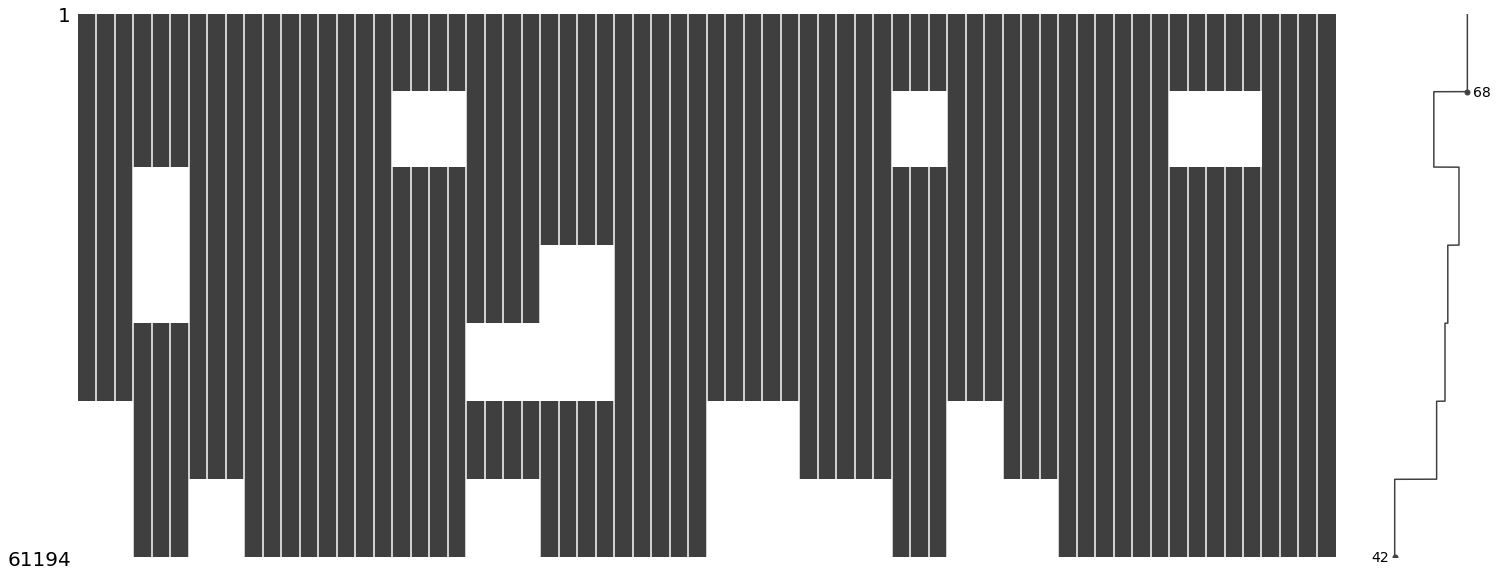

In [10]:
msno.matrix(df)

#### Dendrograma de valores faltantes

Un dendograma de valores faltantes puede ayudar a entender qué columnas suelen ausentarse juntas. Esto permite entender el motivo de por qué las columnas se ausentan, y la relación que tiene con las demás.

<AxesSubplot:>

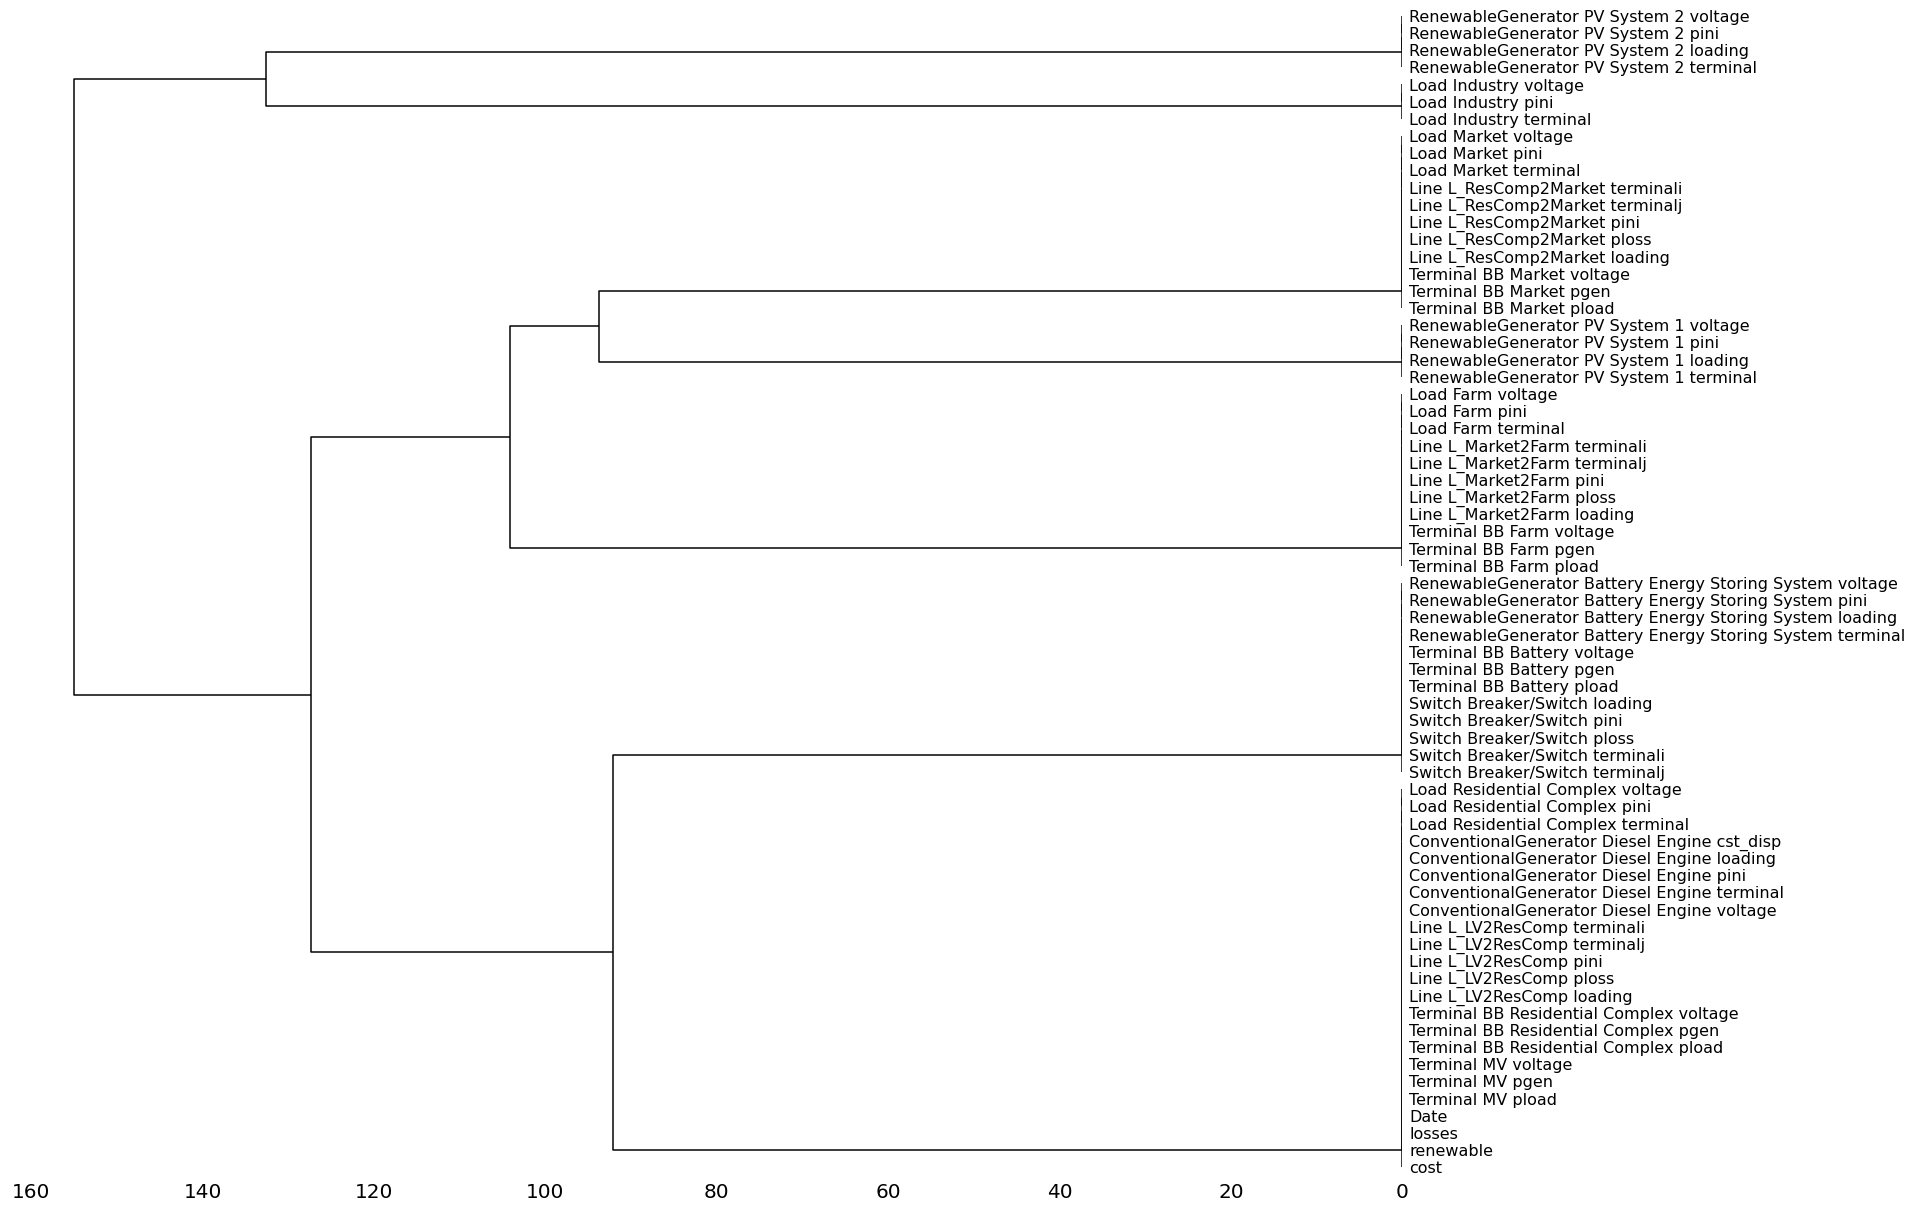

In [11]:
msno.dendrogram(df)

#### Correlación entre valores faltantes

Finalmente, una matriz de correlación entre valores faltantes indica la correlación entre la ausencia de las variables.

<AxesSubplot:>

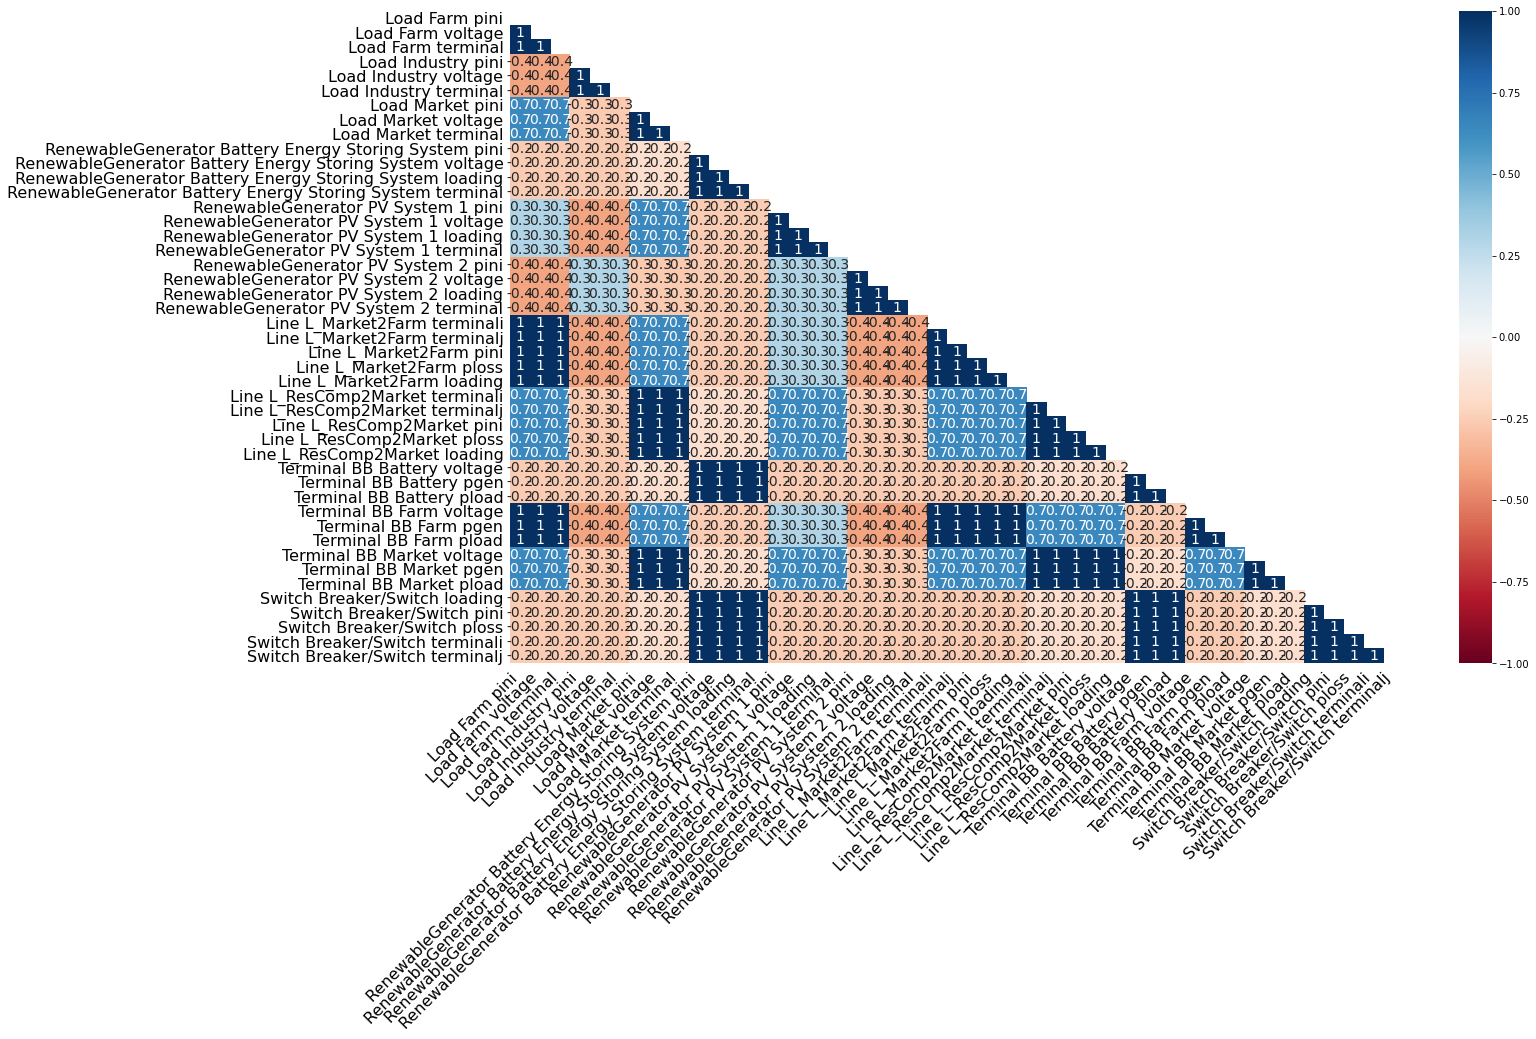

In [12]:
msno.heatmap(df)

### Procesado de valores faltantes

Con la información obtenida en los anteriores gráficos y considerando el contexto del problema, se decide que la forma de procesar los valores faltantes se realizará rellenado los valores ausentes con un valor nuetro, que represente esta ausencia. Este valor corresponde a 0.

In [13]:
df = df.replace(np.NaN, 0)

Se comprueba que el dataset está completo (No hay valores faltantes)

<AxesSubplot:>

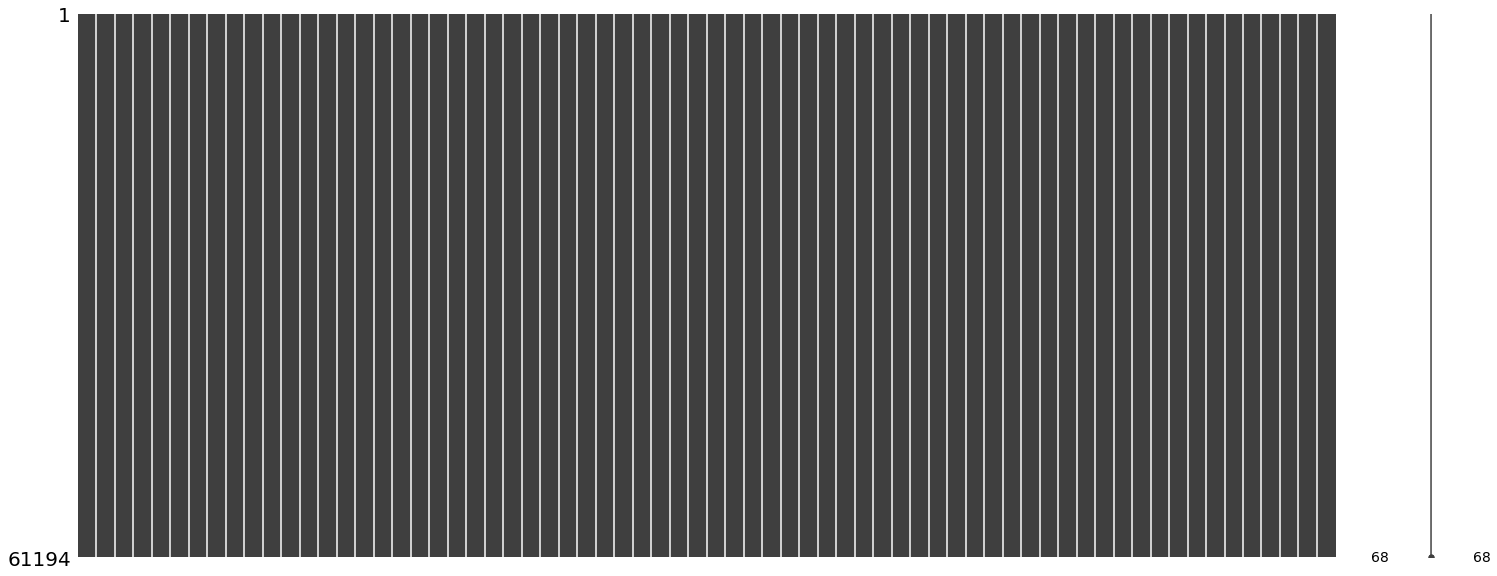

In [14]:
msno.matrix(df)

### Eliminación de columnas con baja varianza

Ya que para el proyecto es más importante la interpretablidad de los modelos generados, se debe disminuir la cantidad de alteraciones que se realizan al dataset. Con la finalidad de simplificar el dataset sin alterar la posible interpretación de resultados, se decide eliminar las columnas que tienen varianza 0, es decir, el mismo valor en todo el dataset.

In [15]:
df.shape

(61194, 68)

In [16]:
# Instacniar algortimo para filtrar por varianza
selector = VarianceThreshold()

# Se obtienen las columnas del dataset descartando las columnas correspondientes al vector de salida
columns = df.columns.drop(['Date', 'renewable', 'cost', 'losses']).drop([x for x in df.columns if 'terminal' in x])

# Se obtienen las columnas sin variación, descartando anteriormente las columnas del vector de salida y las columnas correspondientes a etiquetas
selector.fit(df.drop(columns=['Date', 'renewable', 'cost', 'losses']).drop(columns=[x for x in df.columns if 'terminal' in x]))

VarianceThreshold()

In [17]:
# Se separan columnas entre seleccionadas a mantener y columnas removidas
selected_columns = list()
removed_columns = list()

for column, selected in zip(columns, selector.get_support()):
    if selected:
        selected_columns.append(column)
    else:
        removed_columns.append(column)

# Indicar que columnas han sido removidas
print('Columnas removidas por baja varianza:\n', removed_columns)

Columnas removidas por baja varianza:
 ['Load Farm pini', 'Load Industry pini', 'Load Market pini', 'Load Residential Complex pini', 'Terminal BB Battery pload', 'Terminal BB Farm pgen', 'Terminal BB Farm pload', 'Terminal BB Market pload', 'Terminal BB Residential Complex pgen', 'Terminal BB Residential Complex pload', 'Terminal MV pload', 'Switch Breaker/Switch loading']


In [18]:
# De aqui en adelante, el Notebook opera con el dataset descartando las columnas con varianza cero, y las columnas que corresponden a etiquetas.
if REMOVE_COLUMNS:
    df = df.drop(columns=removed_columns)
    df.shape

### Correlación entre columnas del dataset

Para finalizar la fase de entendimiento de datos, se analiza la correlación entre columnas mediante un gráfico. Debido al contexto del proyecto, este análisis se hace con un mayor interés en verificar la coherencia de los datos. Debido a la necesidad de no alterar el dataset, no se realiza ingeniería de características.

In [19]:
# Obtener matriz de correlación entre columnasm redondando a dos decimales y descratando valores nulos.
corr_df = df.drop(columns=['losses', 'renewable', 'cost']).corr().round(decimals=2).dropna(how='all', axis=1).dropna(how='all', axis=0)

<AxesSubplot:>

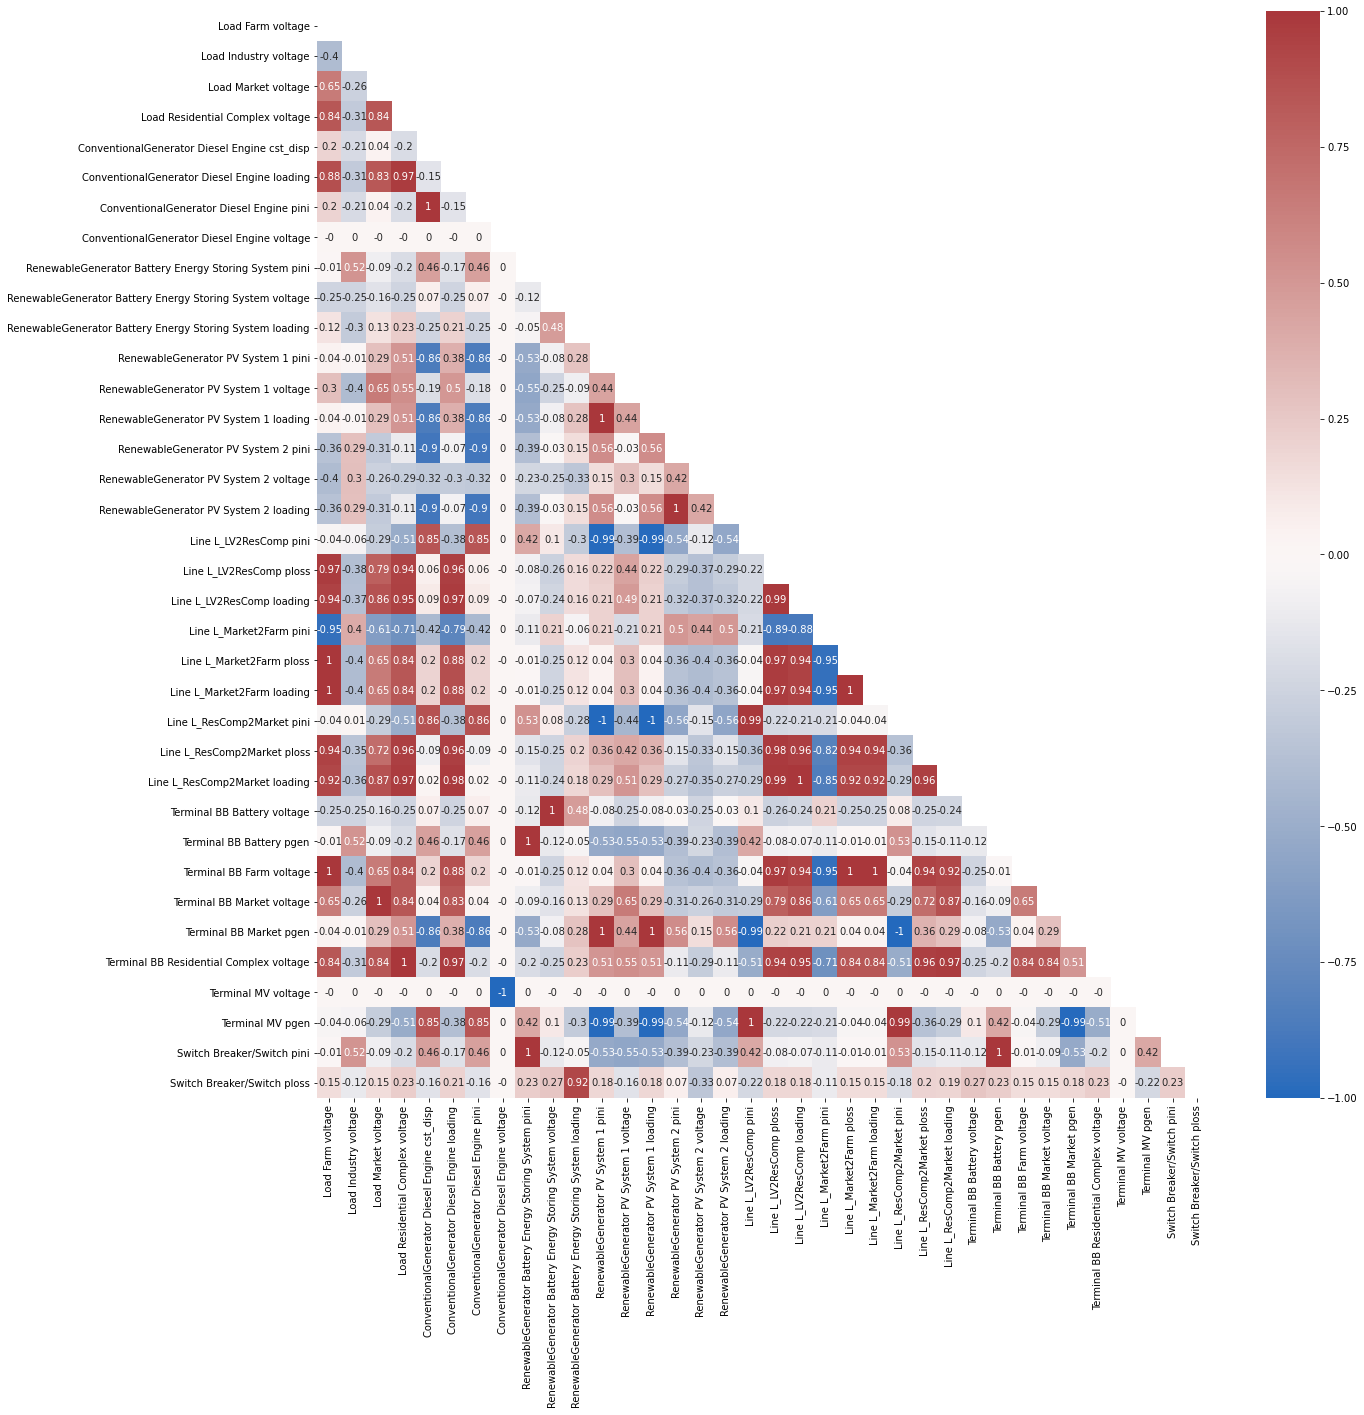

In [20]:
# Crear figura para el gráfico
fig, ax = plt.subplots(figsize=(20,20))

# Máscara para representar sólo la mitad de la matriz de correlación
mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)] = True

# Dibujar matriz
sns.heatmap(corr_df, ax=ax, annot=True, mask=mask, cmap=sns.color_palette("vlag", as_cmap=True))

## Fase de modelado

### Entrenamiento de Modelos con hiperparámetros predeterminados

Se comienza la fase de modelado entrenando modelos con hiperparámetros preterminados. El propósito es tener resultdos preliminares respecto al rendimineto de caga algoritmo aplicado en el dataset, y tener un punto de comparación una vez se realice la optimización de hiperparámetros.

In [21]:
# Se obtiene una muestra del dataset si así se ha configurado
# Se considera el dataset completo de lo contrario
if SHOULD_SAMPLE:
    dataset = df.sample(frac=SAMPLE_PER, random_state = RAND_STATE)
else:
    dataset = df

# Shuffle dataset
dataset = dataset.sample(frac=1, random_state=RAND_STATE).reset_index(drop=True)

# Obtener vectores de entrada y salida
X = dataset.drop(columns=['Date', 'renewable', 'cost', 'losses']).drop(columns=[x for x in dataset.columns if 'terminal' in x])
y = dataset[['losses', 'renewable', 'cost']]

# Escalar datos de entrada
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Separar datos en conjuntos de entrenamiento y prueba
X, X_test, y, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RAND_STATE)

# Hacer kfold, shuffle dataset
cv = KFold(n_splits=N_FOLDS, random_state=RAND_STATE, shuffle=True)

# Entrenar modelos
model_scores = {}
for key, estimator in estimators.items():
    model_scores[key] = cross_validate(estimator, X, y, cv=cv, scoring=('neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'), n_jobs=-1, return_estimator=True)


#### Puntaje medio obtenido en validación cruzada, hiperparámetros predeterminados

Se realiza un breve análisis a los resultados obtenidos, para tener resultados preliminares respecto al rendimiento de cada algoritmo.

In [22]:
# Obtener promedio de puntajes en cada métrica por cada algoritmo
model_scores_df =  pd.DataFrame.from_dict(model_scores).drop('estimator')
model_scores_df = model_scores_df.apply(lambda x: x.apply(lambda y: np.mean(y)), axis=1)
model_scores_df

,SGD,Linear,SVR,RandomForest,GradientBoosting,MLP
fit_time,0.0427,0.0447,0.6858,6.6543,6.2115,1.4012
score_time,0.0113,0.0131,0.1354,0.0343,0.0146,0.0139
test_neg_mean_squared_error,-0.0258,-0.0205,-0.0221,-0.0033,-0.0085,-0.0174
test_neg_mean_absolute_error,-0.0673,-0.0518,-0.0487,-0.0057,-0.0230,-0.0479
test_r2,0.6715,0.7370,0.2279,0.9606,0.9175,-4.3170


### Preparación de resultados obtenidos en validación cruzada

Se reordenan los resultados obtenidos durante el modelado, con el fin de acomodarlos a una tabla que permita gráficar los resultados obtenidos.

In [23]:
filter = {}
cv_scores = {}
test_keys = []
model_keys = list(model_scores.keys())

# Esto filtra los resultados obtenidos, asegurandose que se obtengan los valores de métricas.
for key, item in model_scores.items():
    item_keys = [x for x in item.keys() if 'test' in x]
    test_keys = item_keys
    filter[key] = {}
    for ikey in item_keys:
        filter[key][ikey] = item[ikey]

# Esto invierte los diccionarios, para cambiar qué atributo agrupa los valores
for test in test_keys:
    cv_scores[test] = {}
    for model in model_keys:
        cv_scores[test][model] = filter[model][test]

### Evaluación de modelos en conjunto de prueba, hiperparámetros predeterminados

Se evaluan los modelos en el conjunto de prueba, usando hiperparámetros predeterminados.

In [24]:
test_scores = { 'MAE': {}, 'R2': {}, 'MSE': {}}

# Se preparan las listas para almacenar los resultados de cada estimador
for key, item in model_scores.items():
    test_scores['MAE'][key] = list()
    test_scores['R2'][key] = list()
    test_scores['MSE'][key] = list()
    # Se obtiene el modelo y se evalua su predicción en las tres métricas designadas en el proyecto
    for estimator in model_scores[key]['estimator']:
        y_pred = estimator.predict(X_test)
        test_scores['MAE'][key].append(mean_absolute_error(y_test, y_pred))
        test_scores['MSE'][key].append(mean_squared_error(y_test, y_pred))
        test_scores['R2'][key].append(r2_score(y_test, y_pred))


### Visualización de resultados durante evaluación cruzada

Se definen diccionarios para ser usados durante la visualización y almacenamiento de datos.

In [25]:
# Este diccionario es usado para la visualización de resultados
test_label_dict = {'test_neg_mean_absolute_error': 'Puntaje error absoluto medio (MAE) (Recortado en 0 mín.)',
                   'test_neg_mean_squared_error': 'Puntaje error cuadrático medio (RMSE) (Recortado en 1 máx.)',
                   'test_r2': 'Puntaje R2 (Recortado en 0 mín.)'}

# Este diccionario es usado para almacenar los resultados
test_csv_dict = {'test_neg_mean_absolute_error': 'MAE',
                 'test_neg_mean_squared_error': 'MSE',
                 'test_r2': 'R2'}

Se grafican los resultados obtenidos por cada modelo entrenado durante la validación cruzada. Para facilitar la legibilidad de los gráficos, en todos los gráficos del Notebook se recortan los valores, recortando las valores obtenidos en cada métrica entre los valores [0, 1] y redondeando los puntajes a 2 decimales. 

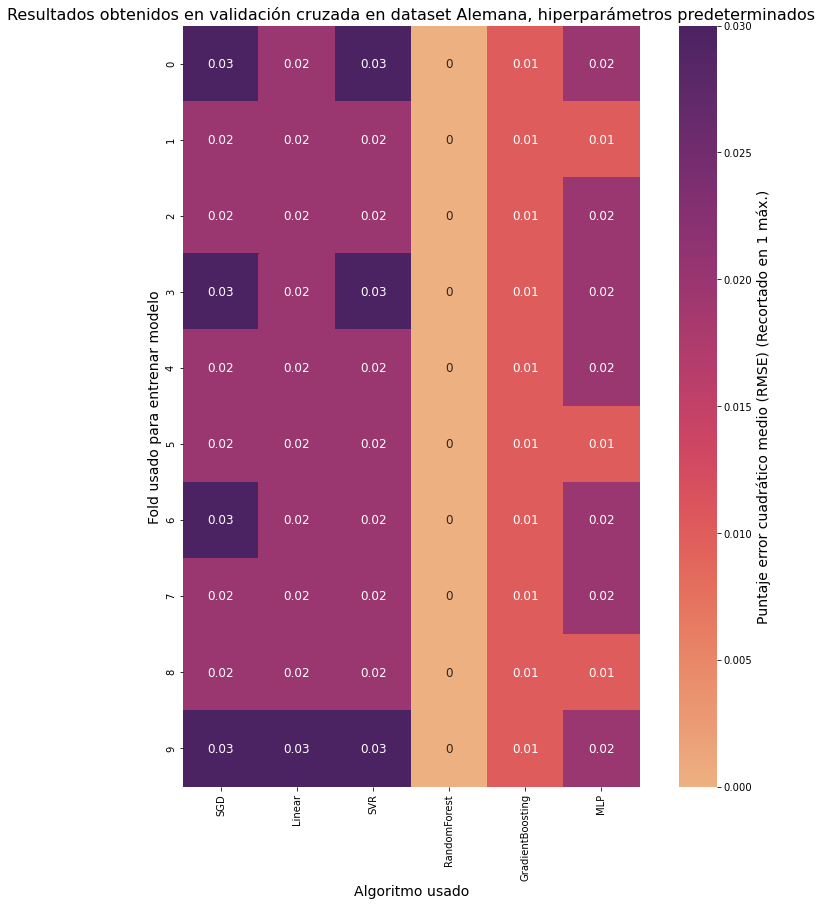

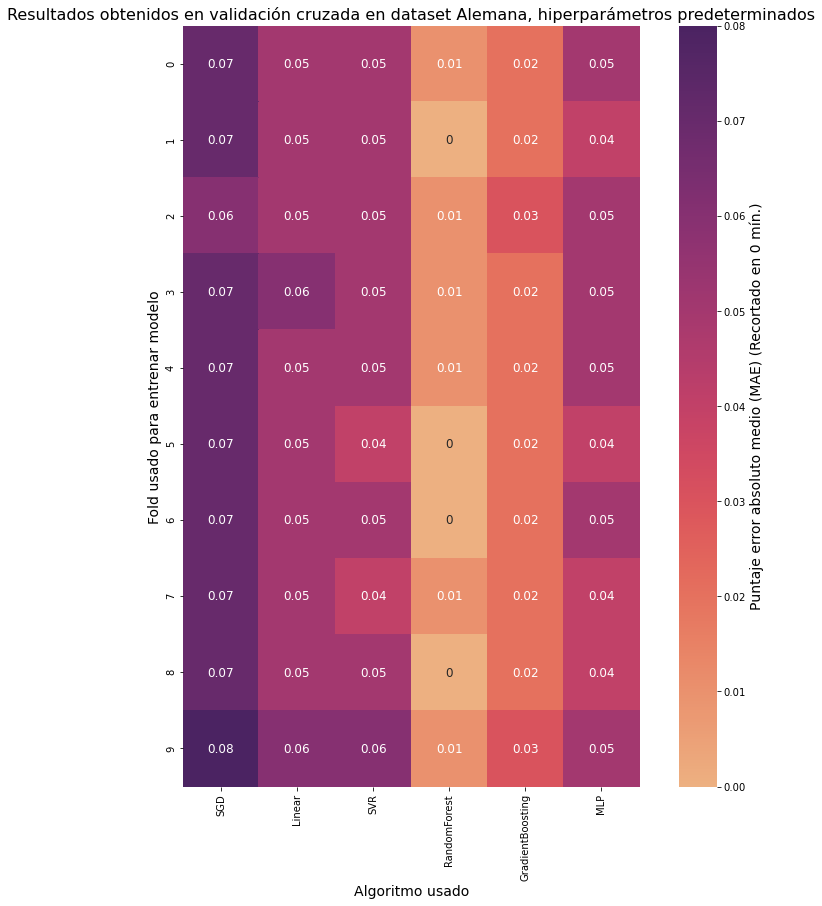

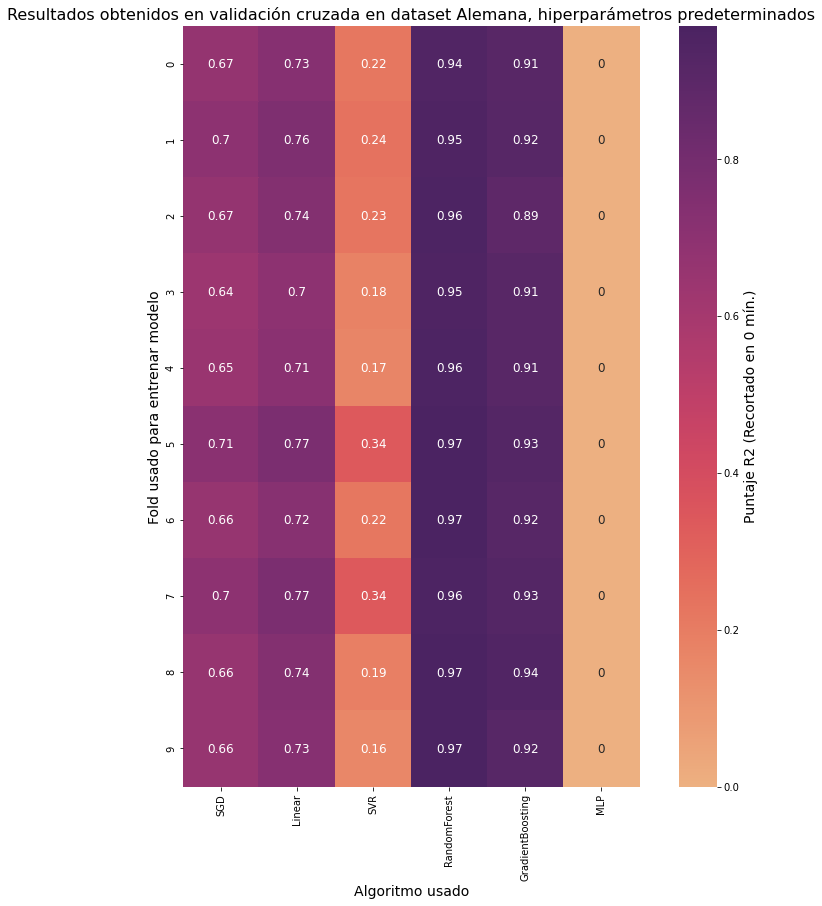

In [26]:
for test, results in cv_scores.items():
    fig, ax = plt.subplots(figsize=(14, 14))
    fig_df = pd.DataFrame.from_dict(results)

    # Invertir puntajes MSE y MAE
    if 'neg' in test:
        fig_df = fig_df.apply(lambda x: x.apply(lambda y: -y))
    
    # Almacenar resultados en disco. Estos datos son luego usados por el notebook auxiliar de visualización
    fig_df.to_csv('{}/csv/{}_{}_cross_val_pred_hyper.csv'.format(NOTEBOOK_FOLDER_PATH, DATASET_NAME, test_csv_dict[test]))

    # Diujar gráfico, simplificando puntajes obtenidos
    ax = sns.heatmap(fig_df.clip(lower=0, upper=1).round(decimals=2),
                    annot = True, 
                    cmap=sns.color_palette('flare', as_cmap=True), 
                    cbar_kws={'label': test_label_dict[test]},
                    square=True,
                    annot_kws={'fontsize': 'large', 'fontweight': 'medium'})
    
    # Personalizar etiquetas
    ax.set_title('Resultados obtenidos en validación cruzada en dataset {}, hiperparámetros predeterminados'.format(DATASET_NAME), fontsize = 16)
    ax.set_xlabel('Algoritmo usado', fontsize = 14)
    ax.set_ylabel('Fold usado para entrenar modelo', fontsize = 14)
    ax.figure.axes[-1].yaxis.label.set_size(14)

    plt.show()

### Preparación de resultados en conjunto de prueba

Se preparan las tablas con los resultados obtenidos al evaluar los modelos entrenados en el conjunto de prueba. Estas tablas son almacenadas en formato csv, con el fin de ser usadas en el Notebook auxiliar de gráficos.

In [27]:
test_scores_dfs = {}

# Por cada métrica, formar un dataframe con los datos y almacenar resultados obtenidos
for test in ['MAE', 'MSE', 'R2']:
    test_scores_dfs[test] = pd.DataFrame.from_dict(test_scores[test])
    test_scores_dfs[test].to_csv('{}/csv/{}_{}_test_pred_hyper.csv'.format(NOTEBOOK_FOLDER_PATH, DATASET_NAME, test))

### Visualización de resultados obtenidos en conjunto de prueba

Se grafican los resultados obtenidos por cada modelo evaluados en el conjunto de pruebas.

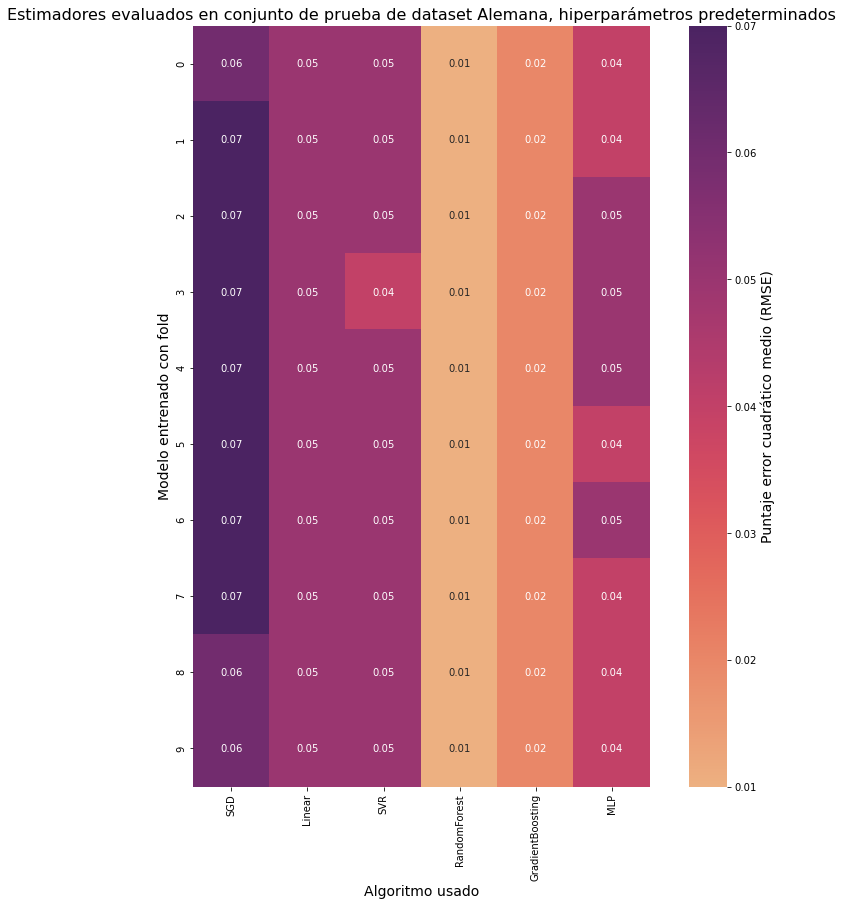

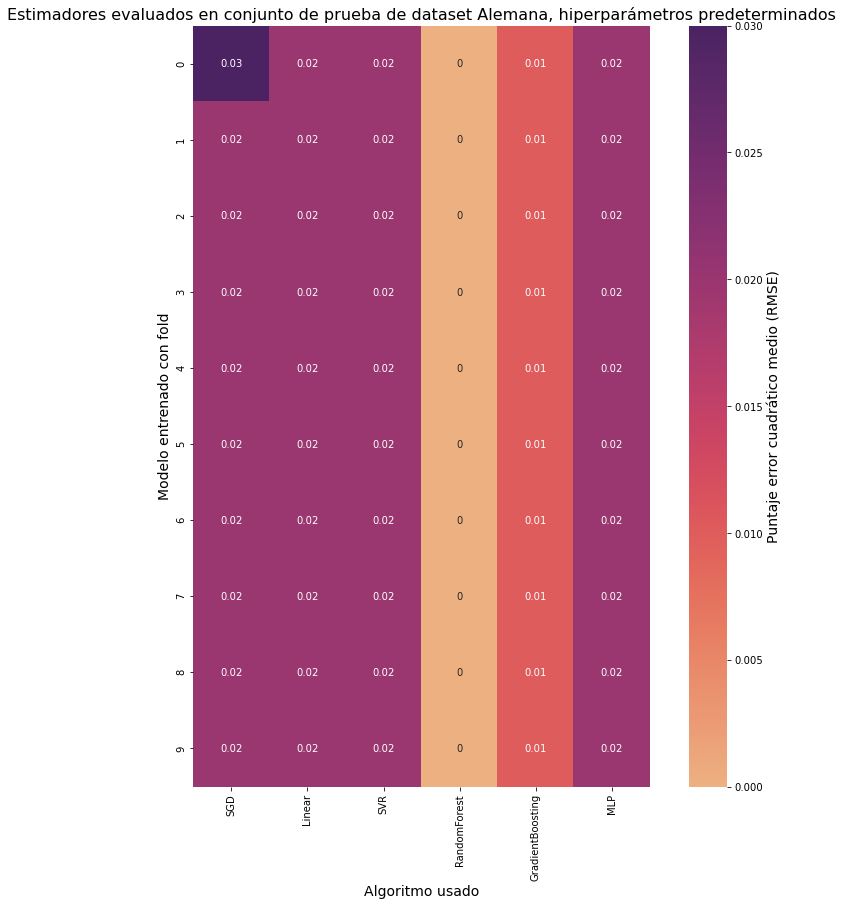

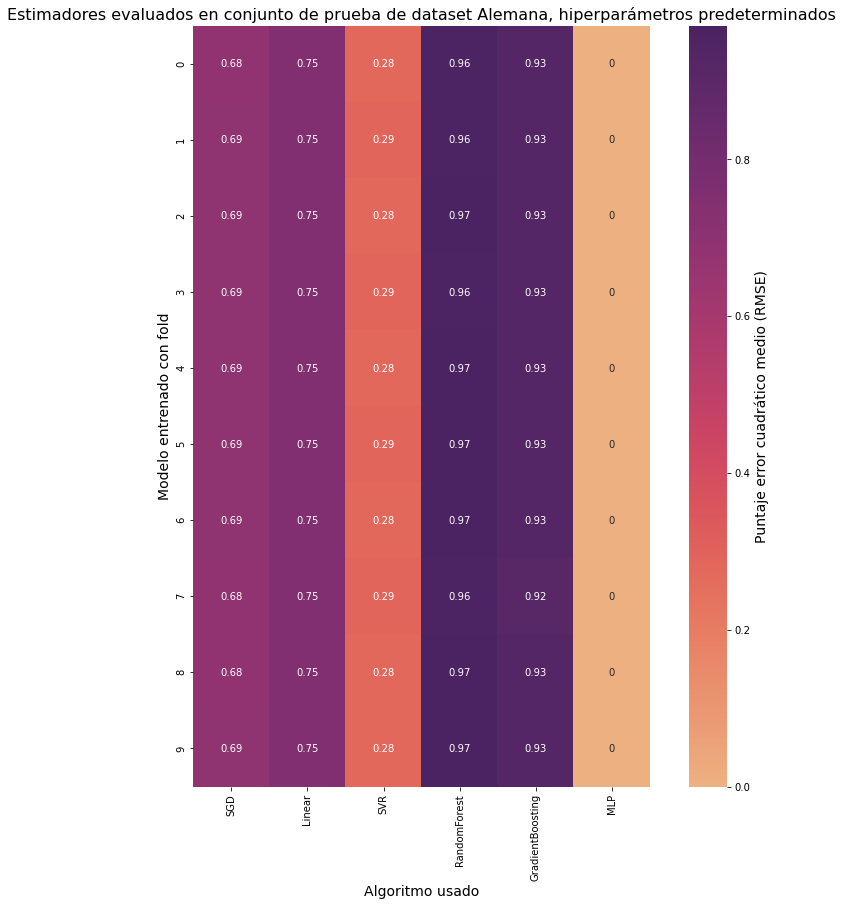

In [28]:
for test, df in test_scores_dfs.items():
    fig, ax = plt.subplots(figsize=(14, 14))

    # Invertir puntajes MSE y MAE
    if 'neg' in test:
        df = df.apply(lambda x: x.apply(lambda y: -y))

    # Diujar gráfico, simplificando puntajes obtenidos
    ax = sns.heatmap(df.round(decimals=2).clip(lower=0, upper=1).round(decimals=2),
                     annot = True,
                     cmap=sns.color_palette('flare', as_cmap=True),
                     square=True,
                     cbar_kws={'label': 'Puntaje error cuadrático medio (RMSE)'})
    
    # Personalizar etiquetas
    ax.set_title('Estimadores evaluados en conjunto de prueba de dataset {}, hiperparámetros predeterminados'.format(DATASET_NAME), fontsize = 16)
    ax.set_xlabel('Algoritmo usado', fontsize = 14)
    ax.set_ylabel('Modelo entrenado con fold', fontsize = 14)
    ax.figure.axes[-1].yaxis.label.set_size(14)

    plt.show()

### Optimización de hiperparámetros

Se inician nuevos estimadores para la búsqueda de hiperparámetros.

In [29]:
estimators = {'SGD': RegressorChain(base_estimator=SGDRegressor(max_iter=1000, random_state=RAND_STATE), random_state=RAND_STATE),
              'Linear': RegressorChain(base_estimator=LinearRegression(), random_state=RAND_STATE),
              'SVR': RegressorChain(base_estimator=SVR(), random_state=RAND_STATE),
              'RandomForest': RandomForestRegressor(random_state=RAND_STATE),
              'GradientBoosting': RegressorChain(base_estimator=GradientBoostingRegressor(random_state=RAND_STATE), random_state=RAND_STATE),
              'MLP': MLPRegressor(random_state=RAND_STATE)}

Se define el espacio de búsqueda para cada hiperparámetro en cada algoritmo.

In [30]:
# Definir espacios de búsqueda de hiperparámetros para cada hiperparametro,
# Para cada algoritmo.
# Los hiperparámetros de los algoritmos que usan RegressorChain deben tener
# el prefijo 'base_estimator__' para ser usados correctamente.
hyper_spaces = {
    'SGD': {
        'base_estimator__loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
        'base_estimator__penalty': ['l2', 'l1', 'elasticnet'],
        'base_estimator__learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    },
    'Linear': {
        'base_estimator__fit_intercept': [True, False]
    },
    'SVR': {
        'base_estimator__kernels': ['linear', 'poly', 'rbf', 'sigmoid'],
        'base_estimator__C': [1, 10, 100],
        'base_estimator__epsilon': [0.1, 1, 10]
    },
    'RandomForest': {
        'n_estimators': [10, 50, 100, 200, 400],
        'criterion': ['squared_error', 'poisson'],
        'max_depth': [None, 10, 100, 200], 
    },
    'GradientBoosting': {
        'base_estimator__loss': ['ls', 'lad', 'huber', 'quantile'],
        'base_estimator__learning_rate': [0.01, 0.1, 1],
        'base_estimator__n_estimators': [50, 100, 200],
        'base_estimator__criterion': ['friedman_mse', 'mse']
    },
    'MLP': {
        'hidden_layer_sizes': [(10,), (20,), (40,), (10, 10,), (20, 10), (40, 10,)],
        'solver': ['lbfgs', 'sgd', 'adam'],
        'activation': ['logistic', 'tanh'],
        'learning_rate': ['constant', 'invscaling', 'adaptive']
    }
}

Se ejecuta la búsqueda de hiperparámetros. Esta es una tarea que en comparación al tiempo de ejecución del resto del notebook, toma bastante tiempo. Por lo tanto, la búsqueda de hiperparámetros optimos se omite. Sin embargo, esta tarea puede ser ejecuatada de todos modos para usar sus resultados en el resto de la ejecución del notebook.

Para la búsqueda de hiperparámetros óptimos, se comienza definiendo una máscara para realizar 3 repeticiones de k-fold cross-validation. Luego, se toman las columnas necesarias de la muestra del total de datos elegida anteriormente. Luego, por cada algoritmo, se hace la búsqueda. De esta búsqueda se almacenan en disco los resultados obtenidos en formato csv, y la mejor configuración de hiperparámetros por cada algoritmo en formato json. 

In [34]:
if GRIDSEARCH:
    # Definir repeated k-fold cv
    cv = RepeatedKFold(n_splits=N_FOLDS, n_repeats=N_REPEATS, random_state=RAND_STATE)
    
    # Obtener vectores de entrada y salida
    X = dataset.drop(columns=['Date', 'renewable', 'cost', 'losses']).drop(columns=[x for x in dataset.columns if 'terminal' in x])
    y = dataset[['losses', 'renewable', 'cost']]

    # Búsqueda de hiperparámetros óptimos en cada modelo
    opt_param_dict = {}
    for name, model in estimators.items():
        # Realizar búsqueda
        search = GridSearchCV(model, hyper_spaces[name], scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv)
        
        # Almacenar resultados en formato csv, hiperparámetros óptimos
        result = search.fit(X, y)
        results_df = pd.DataFrame.from_dict(result.cv_results_)
        results_df.to_csv('{}/csv/{}_{}_HyperScores.csv'.format(NOTEBOOK_FOLDER_PATH, DATASET_NAME, name))
        
        # Es necesario sacar el substring "base_estimator__" de las keys de best_params_
        best_params = {k.replace('base_estimator__', ''):v for k,v in search.best_params_.items()}
        opt_param_dict[name] = best_params

    with open(HYPERPARAMETERS_CONFIG_FILEPATH, 'w', encoding='utf-8') as f:
        json.dump(opt_param_dict, f, ensure_ascii=False, indent=4)

else:
    # Si se omite la optimización de hiperparámetros, se carga la configuración desde el disco
    print('GridSearch omitido.')
    with open(HYPERPARAMETERS_CONFIG_FILEPATH) as json_file:
        opt_param_dict = json.load(json_file)


GridSearch omitido.


### Entrenamiento de modelos con hiperparámetros óptimos

Una vez se han encontrado hiperparámetros óptimos, se crean nuevos estimadores, asignando los valores óptimos correspondientes.

Se comienza iniciando nuevamente los estimadores, esta vez haciendo uso de los hiperparámetros óptimos encontrados en la actividad anterior.

In [35]:
estimators = {'SGD': RegressorChain(base_estimator=SGDRegressor(max_iter=1000,
                                                                random_state=RAND_STATE,
                                                                **opt_param_dict['SGD']), 
                                                                random_state=RAND_STATE),
              'Linear': RegressorChain(base_estimator=LinearRegression(**opt_param_dict['Linear']),
                                                                random_state=RAND_STATE),
              'SVR': RegressorChain(base_estimator=SVR(**opt_param_dict['SVR']),
                                                    random_state=RAND_STATE),
              'RandomForest': RandomForestRegressor(random_state=RAND_STATE,
                                                                **opt_param_dict['RandomForest']),
              'GradientBoosting': RegressorChain(base_estimator=GradientBoostingRegressor(
                                                                random_state=RAND_STATE,
                                                                **opt_param_dict['GradientBoosting']), 
                                                                random_state=RAND_STATE),
              'MLP': MLPRegressor(random_state=RAND_STATE, 
                                    **opt_param_dict['MLP'])}

Se entrenan los nuevos modelos

In [36]:
# Shuffle dataset
dataset = dataset.sample(frac=1, random_state=RAND_STATE).reset_index(drop=True)

# Obtener vectores de entrada y salida
X = dataset.drop(columns=['Date', 'renewable', 'cost', 'losses']).drop(columns=[x for x in dataset.columns if 'terminal' in x])
y = dataset[['losses', 'renewable', 'cost']]

# Escalar valores de entrada
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Separar en conjuntos de entrenamiento y prueba
X, X_test, y, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RAND_STATE)

# Hacer kfold, shuffle dataset
cv = KFold(n_splits=N_FOLDS, random_state=RAND_STATE, shuffle=True)

# Entrenar modelos
model_scores = {}
for key, estimator in estimators.items():
    model_scores[key] = cross_validate(estimator, X, y, cv=cv, scoring=('neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'), n_jobs=-1, return_estimator=True)


### Procesamiento de resultados obtenidos en validación cruzada, hiperparámetros óptimos

Se procesan los resultados obtenidos, con tal de expresarlos como tabla.

In [37]:
model_scores_df = pd.DataFrame.from_dict(model_scores).drop('estimator')
model_scores_df = model_scores_df.apply(lambda x: x.apply(lambda y: np.mean(y)), axis=1)

# Procesar resultados para ser expresados en tablas
filter = {}
cv_scores = {}
test_keys = []
model_keys = list(model_scores.keys())

# Esto filtra los resultados obtenidos, asegurandose que se obtengan los valores de métricas.
for key, item in model_scores.items():
    item_keys = [x for x in item.keys() if 'test' in x]
    test_keys = item_keys
    filter[key] = {}
    for ikey in item_keys:
        filter[key][ikey] = item[ikey]

# Esto invierte los diccionarios, para cambiar qué atributo agrupa los valores
for test in test_keys:
    cv_scores[test] = {}
    for model in model_keys:
        cv_scores[test][model] = filter[model][test]

### Evaluación de modelos entrenados en conjunto de evaluación, hiperparámetros óptimos

Se evaluan los modelos entrenados con hiperparámetros óptimos en el conjunto de prueba.

In [38]:
test_scores = {'MAE': {}, 'R2': {}, 'MSE': {}}

# Se preparan las listas para almacenar los resultados de cada estimador
for key, item in model_scores.items():
    test_scores['MAE'][key] = list()
    test_scores['R2'][key] = list()
    test_scores['MSE'][key] = list()
    # Se obtiene el modelo y se evalua su predicción en las tres métricas designadas en el proyecto
    for estimator in model_scores[key]['estimator']:
        y_pred = estimator.predict(X_test)
        test_scores['MAE'][key].append(mean_absolute_error(y_test, y_pred))
        test_scores['MSE'][key].append(mean_squared_error(y_test, y_pred))
        test_scores['R2'][key].append(r2_score(y_test, y_pred))

### Visualización de resultados obtenidos en validación cruzada, hiperparámetros óptimos

Se grafican los resultados obtenidos en la validación cruzada por los modelos entrenados con hiperparámetros óptimos.

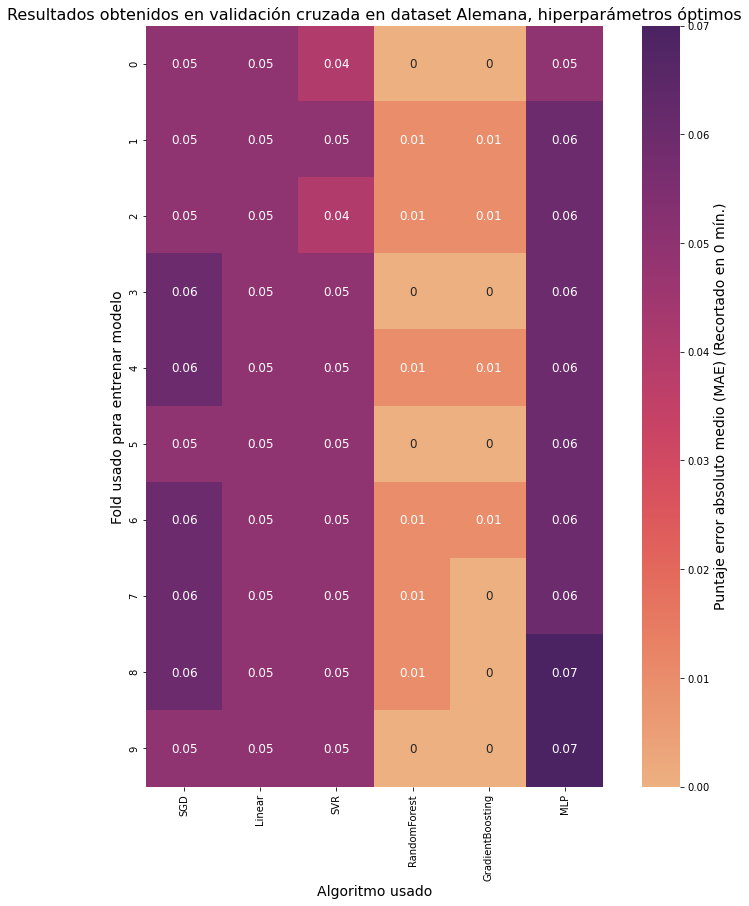

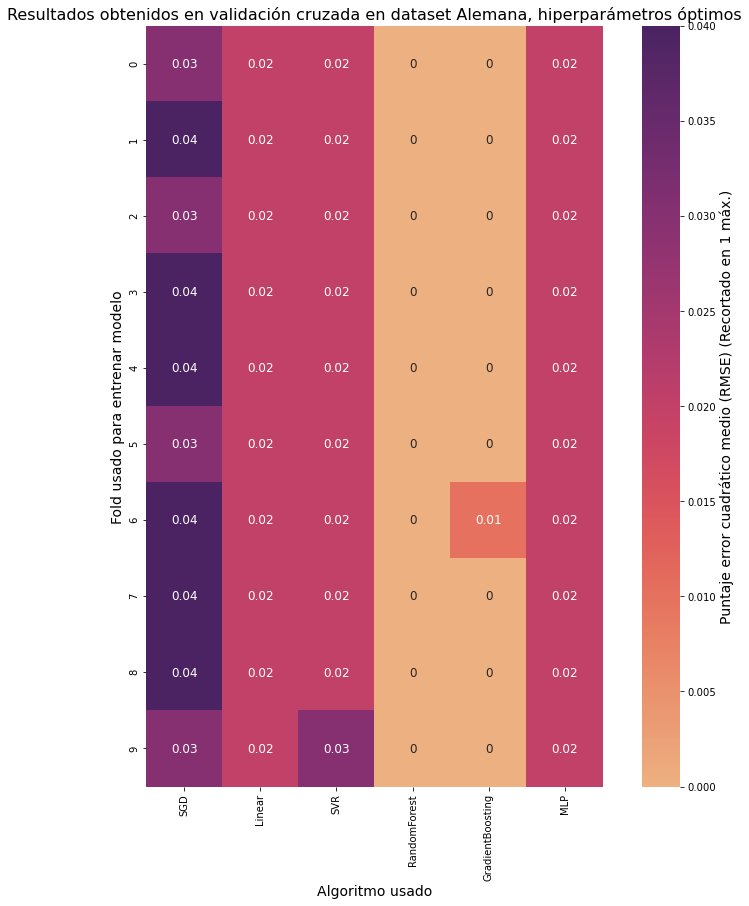

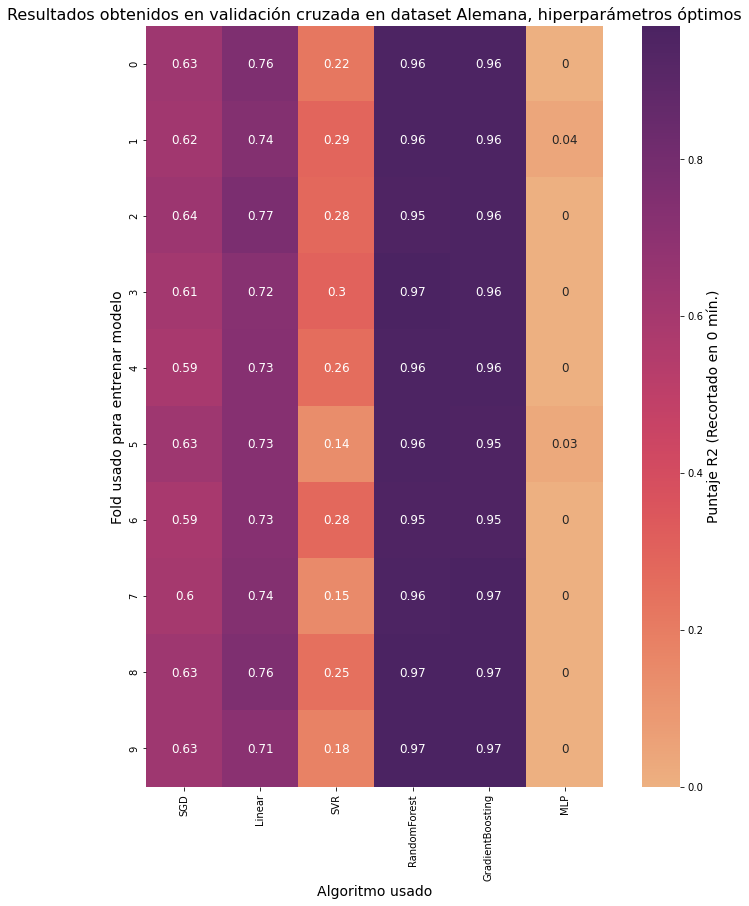

In [39]:
# Graficar resultados validación cruzada
# Hiperparámetros óptimos
for test, results in cv_scores.items():
    fig, ax = plt.subplots(figsize=(14, 14))
    fig_df = pd.DataFrame.from_dict(results)

    # Invertir puntajes MSE y MAE
    if 'neg' in test:
        fig_df = fig_df.apply(lambda x: x.apply(lambda y: -y))
    
    # Almacenar resultados en disco. Estos datos son luego usados por el notebook auxiliar de visualización
    fig_df.to_csv('{}/csv/{}_{}_cross_val_opt_hyper.csv'.format(NOTEBOOK_FOLDER_PATH, DATASET_NAME, test_csv_dict[test]))

    # Diujar gráfico, simplificando puntajes obtenidos
    ax = sns.heatmap(fig_df.clip(lower=0, upper=1).round(decimals=2),
                     annot = True, cmap=sns.color_palette('flare', as_cmap=True), 
                     cbar_kws={'label': test_label_dict[test]},
                     square=True,
                     annot_kws={'fontsize': 'large', 'fontweight': 'medium'})
    
    # Personalizar etiquetas
    ax.set_title('Resultados obtenidos en validación cruzada en dataset {}, hiperparámetros óptimos'.format(DATASET_NAME), fontsize = 16)
    ax.set_xlabel('Algoritmo usado', fontsize = 14)
    ax.set_ylabel('Fold usado para entrenar modelo', fontsize = 14)
    ax.figure.axes[-1].yaxis.label.set_size(14)

    plt.show()

### Visualización de resultados obtenidos en conjunto de prueba, hipperparámetros óptimos

Se procesan y se grafican los resultados obtenidos por los modelos entrenados con hiperparametros óptimos evaluados en el conjunto de prueba.

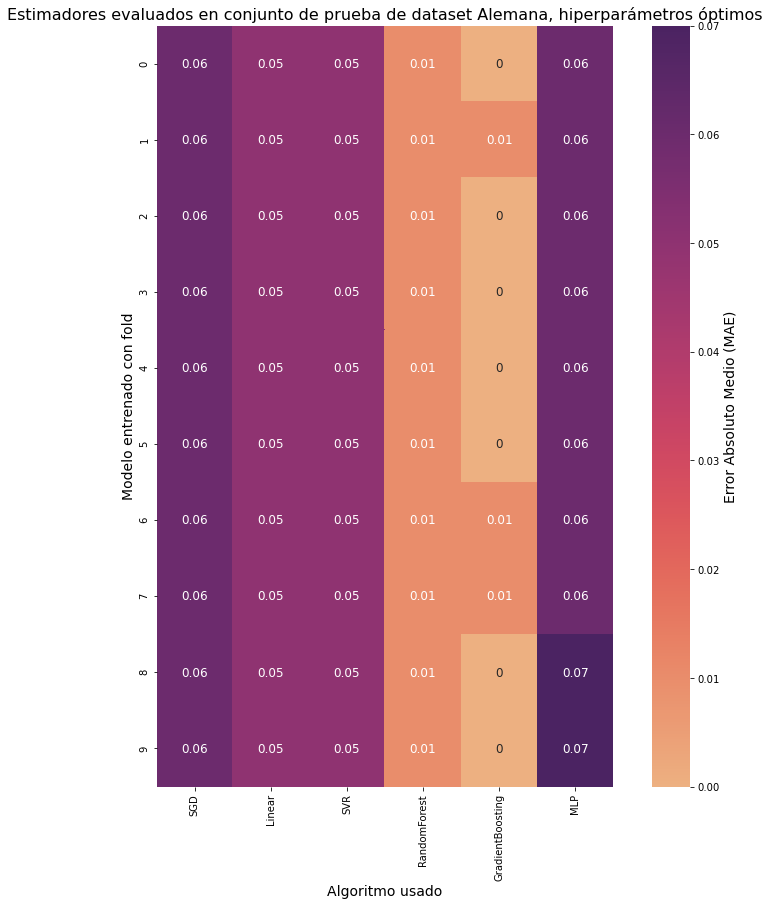

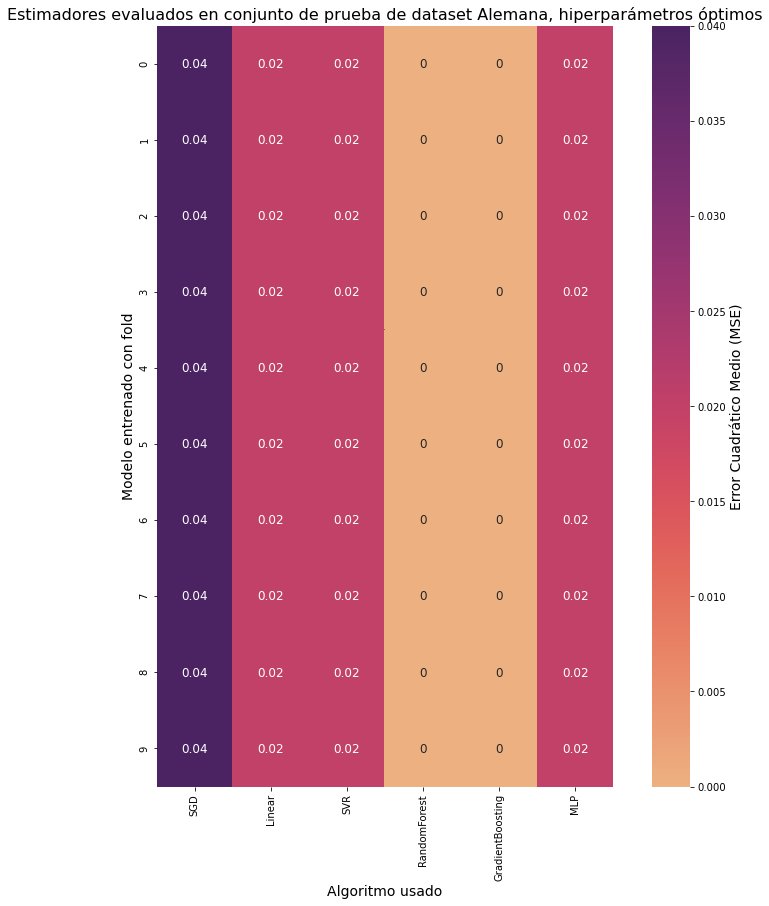

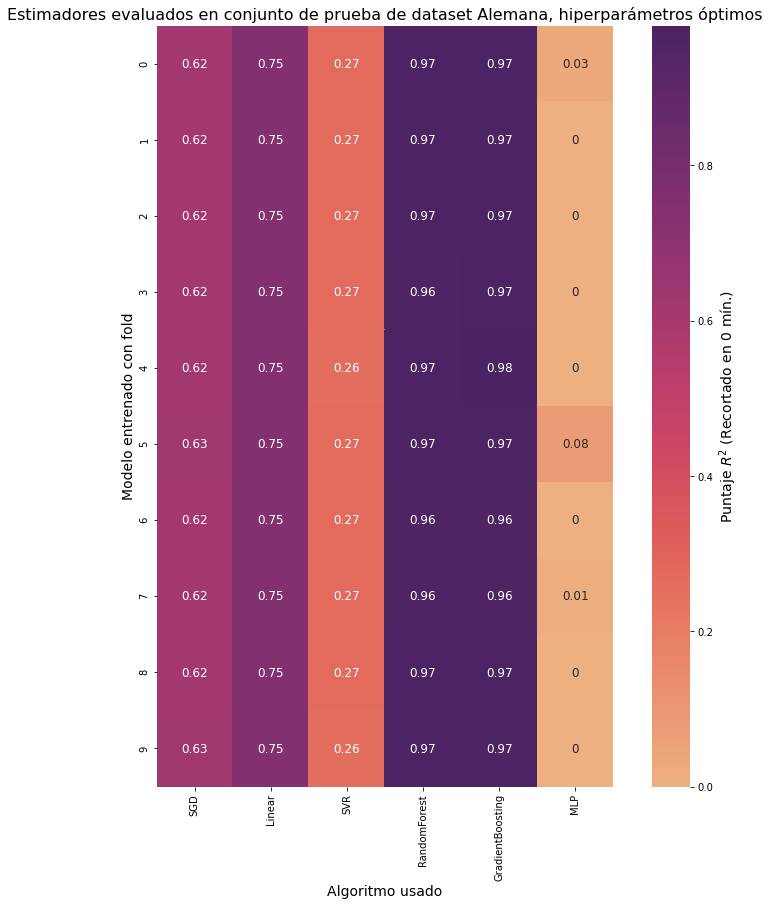

In [40]:
test_scores_dfs = {}

# Preprar etiquetas a usar en gráficos
score_labels = {'MSE': 'Error Cuadrático Medio (MSE)',
               'MAE': 'Error Absoluto Medio (MAE)',
               'R2': 'Puntaje $R^2$ (Recortado en 0 mín.)'}

# Procesar resultados de evaluación en conjunto de prueba y almacenar en disco
for test in ['MAE', 'MSE', 'R2']:
    test_scores_dfs[test] = pd.DataFrame.from_dict(test_scores[test])
    test_scores_dfs[test].to_csv('{}/csv/{}_{}_test_opt_hyper.csv'.format(NOTEBOOK_FOLDER_PATH, DATASET_NAME, test))

# Graficar resultados en conjunto de evaluación
# Hiperparámetros óptimos
for test, df in test_scores_dfs.items():
    fig, ax = plt.subplots(figsize=(14, 14))

    # Invertir puntajes MSE y MAE
    if 'neg' in test:
        df = df.apply(lambda x: x.apply(lambda y: -y))

    # Diujar gráfico, simplificando puntajes obtenidos
    ax = sns.heatmap(df.clip(lower=0, upper=1).round(decimals=2), 
                     annot = True, cmap=sns.color_palette('flare', as_cmap=True), 
                     cbar_kws={'label': score_labels[test]},
                     square=True,
                     annot_kws={'fontsize': 'large', 'fontweight': 'medium'})
    
    # Personalizar etiquetas
    ax.set_title('Estimadores evaluados en conjunto de prueba de dataset {}, hiperparámetros óptimos'.format(DATASET_NAME), fontsize = 16)
    ax.set_xlabel('Algoritmo usado', fontsize = 14)
    ax.set_ylabel('Modelo entrenado con fold', fontsize = 14)
    ax.figure.axes[-1].yaxis.label.set_size(14)

    plt.show()


## Interpretabilidad

A continuación, se evalúa la interpretabilidad de cada modelo, considerando la importancia de atributos en los modelos que lo soportan.

Se obtienen las etiquetas para cada atributo del dataset. Estas son necesarias para indicar a qué característica corresponde la importancia de qué atributo.

In [41]:
X_cols = list(dataset.drop(columns=['Date', 'renewable', 'cost', 'losses']).drop(columns=[x for x in dataset.columns if 'terminal' in x]).columns)
# Para las cadenas de regresores es necesario agregar algunos de los valores de salida
X_cols.append('losses')
X_cols.append('renewable')
col_length = len(X_cols)

### Linear, SVR y SGD

En el caso de Linear, SVR y SGD, para analizar la importancia que tiene cada atributo se considera el peso que el modelo le otorga a cada atributo. Estos puntajes son también escalados aplicando log10, con el fin de obtener el orden de magnitud del peso, y así entender de meor forma la magnitud de la importancia.

In [42]:
# Caso Linear, SVR
for model in ['Linear', 'SVR', 'SGD']:
    estimator = model_scores['Linear']['estimator'][0]
    estimator.estimators_[0].coef_

    # Agregar valores cero en filas donde no hay valores
    pad_coefs = list()
    for estimator in estimator.estimators_:
        pad_coefs.append(np.pad(estimator.coef_, (0, col_length - len(estimator.coef_)), mode='constant', constant_values=0))

    coefs_df = pd.DataFrame(pad_coefs, columns=X_cols).T.set_axis(['losses', 'renewable', 'cost'], axis=1, inplace=False)
    # coefs_df.to_latex('{}_coefs_opt_{}.tex'.format(DATASET_NAME, model))
    print('Coeficientes obtenidos en modelo {} con hiperparámetros óptimos, dataset {}'.format(model, DATASET_NAME))
    display(coefs_df)
    
    coefs_df = coefs_df.apply(lambda x: np.log10(np.maximum(np.abs(x), 1)))
    # coefs_df.to_latex('{}_coefs_opt_log_{}.tex'.format(DATASET_NAME, model))
    print('Orden de magnitud de coeficientes obtenidos en modelo {} con hiperparámetros óptimos, dataset {}'.format(model, DATASET_NAME))
    display(coefs_df)

Coeficientes obtenidos en modelo Linear con hiperparámetros óptimos, dataset Alemana


,losses,renewable,cost
Load Farm voltage,0.0000,126728848156.5701,2052431027.5191
Load Industry voltage,0.0000,-0.1750,0.0030
Load Market voltage,0.0000,41915.8377,1051.1326
Load Residential Complex voltage,0.0000,-583952.6562,-4730.1362
ConventionalGenerator Diesel Engine cst_disp,0.0000,28.2130,-0.2016
ConventionalGenerator Diesel Engine loading,0.0000,-1.6679,0.0174
ConventionalGenerator Diesel Engine pini,0.0000,2621219576.5764,32824483.5650
ConventionalGenerator Diesel Engine voltage,0.0000,-1584464.2153,-5427.1252
RenewableGenerator Battery Energy Storing System pini,0.0000,-311634530.3880,2594260.4938
RenewableGenerator Battery Energy Storing System voltage,0.0000,66588.0909,-548.2603


Orden de magnitud de coeficientes obtenidos en modelo Linear con hiperparámetros óptimos, dataset Alemana


,losses,renewable,cost
Load Farm voltage,0.0000,11.1029,9.3123
Load Industry voltage,0.0000,0.0000,0.0000
Load Market voltage,0.0000,4.6224,3.0217
Load Residential Complex voltage,0.0000,5.7664,3.6749
ConventionalGenerator Diesel Engine cst_disp,0.0000,1.4504,0.0000
ConventionalGenerator Diesel Engine loading,0.0000,0.2222,0.0000
ConventionalGenerator Diesel Engine pini,0.0000,9.4185,7.5162
ConventionalGenerator Diesel Engine voltage,0.0000,6.1999,3.7346
RenewableGenerator Battery Energy Storing System pini,0.0000,8.4936,6.4140
RenewableGenerator Battery Energy Storing System voltage,0.0000,4.8234,2.7390


Coeficientes obtenidos en modelo SVR con hiperparámetros óptimos, dataset Alemana


,losses,renewable,cost
Load Farm voltage,0.0000,126728848156.5701,2052431027.5191
Load Industry voltage,0.0000,-0.1750,0.0030
Load Market voltage,0.0000,41915.8377,1051.1326
Load Residential Complex voltage,0.0000,-583952.6562,-4730.1362
ConventionalGenerator Diesel Engine cst_disp,0.0000,28.2130,-0.2016
ConventionalGenerator Diesel Engine loading,0.0000,-1.6679,0.0174
ConventionalGenerator Diesel Engine pini,0.0000,2621219576.5764,32824483.5650
ConventionalGenerator Diesel Engine voltage,0.0000,-1584464.2153,-5427.1252
RenewableGenerator Battery Energy Storing System pini,0.0000,-311634530.3880,2594260.4938
RenewableGenerator Battery Energy Storing System voltage,0.0000,66588.0909,-548.2603


Orden de magnitud de coeficientes obtenidos en modelo SVR con hiperparámetros óptimos, dataset Alemana


,losses,renewable,cost
Load Farm voltage,0.0000,11.1029,9.3123
Load Industry voltage,0.0000,0.0000,0.0000
Load Market voltage,0.0000,4.6224,3.0217
Load Residential Complex voltage,0.0000,5.7664,3.6749
ConventionalGenerator Diesel Engine cst_disp,0.0000,1.4504,0.0000
ConventionalGenerator Diesel Engine loading,0.0000,0.2222,0.0000
ConventionalGenerator Diesel Engine pini,0.0000,9.4185,7.5162
ConventionalGenerator Diesel Engine voltage,0.0000,6.1999,3.7346
RenewableGenerator Battery Energy Storing System pini,0.0000,8.4936,6.4140
RenewableGenerator Battery Energy Storing System voltage,0.0000,4.8234,2.7390


Coeficientes obtenidos en modelo SGD con hiperparámetros óptimos, dataset Alemana


,losses,renewable,cost
Load Farm voltage,0.0000,126728848156.5701,2052431027.5191
Load Industry voltage,0.0000,-0.1750,0.0030
Load Market voltage,0.0000,41915.8377,1051.1326
Load Residential Complex voltage,0.0000,-583952.6562,-4730.1362
ConventionalGenerator Diesel Engine cst_disp,0.0000,28.2130,-0.2016
ConventionalGenerator Diesel Engine loading,0.0000,-1.6679,0.0174
ConventionalGenerator Diesel Engine pini,0.0000,2621219576.5764,32824483.5650
ConventionalGenerator Diesel Engine voltage,0.0000,-1584464.2153,-5427.1252
RenewableGenerator Battery Energy Storing System pini,0.0000,-311634530.3880,2594260.4938
RenewableGenerator Battery Energy Storing System voltage,0.0000,66588.0909,-548.2603


Orden de magnitud de coeficientes obtenidos en modelo SGD con hiperparámetros óptimos, dataset Alemana


,losses,renewable,cost
Load Farm voltage,0.0000,11.1029,9.3123
Load Industry voltage,0.0000,0.0000,0.0000
Load Market voltage,0.0000,4.6224,3.0217
Load Residential Complex voltage,0.0000,5.7664,3.6749
ConventionalGenerator Diesel Engine cst_disp,0.0000,1.4504,0.0000
ConventionalGenerator Diesel Engine loading,0.0000,0.2222,0.0000
ConventionalGenerator Diesel Engine pini,0.0000,9.4185,7.5162
ConventionalGenerator Diesel Engine voltage,0.0000,6.1999,3.7346
RenewableGenerator Battery Energy Storing System pini,0.0000,8.4936,6.4140
RenewableGenerator Battery Energy Storing System voltage,0.0000,4.8234,2.7390


### Gradient Boosting

Se considera importancia de cada atributo. Mientras mayor el valor, más importante es. Este valor corresponde a Gini Importance / Mean Decrease in Impurity (MDI). En el caso de GradientBoosting, como se trata de un algoritmo adaptado mediante cadena de regresores, se separa la importancia de atributos en cada valor de salida, y estos deben ser incluidos en la lista de atributos usados por el modelo.

In [43]:
estimator = model_scores['GradientBoosting']['estimator'][0]

# Obtener importancia de vada atributo, hacer espacio para valores de salida en la entrada
pad_coefs = list()
for estimator in estimator.estimators_:
    pad_coefs.append(np.pad(estimator.feature_importances_, (0, col_length - len(estimator.feature_importances_)), mode='constant', constant_values=0))

# preparar tabla y mostrar
coefs_df = pd.DataFrame(pad_coefs, columns=X_cols).T.set_axis(['losses', 'renewable', 'cost'], axis=1, inplace=False)
print('Importancia de atributos en modelo GradientBoosting, dataset {}'.format(DATASET_NAME))

coefs_df

Importancia de atributos en modelo GradientBoosting, dataset Alemana


,losses,renewable,cost
Load Farm voltage,0.0000,0.0000,0.0034
Load Industry voltage,0.0000,0.0004,0.0000
Load Market voltage,0.0000,0.0044,0.0000
Load Residential Complex voltage,0.0000,0.0052,0.0161
ConventionalGenerator Diesel Engine cst_disp,0.0000,0.2393,0.0121
ConventionalGenerator Diesel Engine loading,0.0000,0.0971,0.6667
ConventionalGenerator Diesel Engine pini,0.0000,0.0308,0.0092
ConventionalGenerator Diesel Engine voltage,0.0000,0.0000,0.0000
RenewableGenerator Battery Energy Storing System pini,0.0000,0.0373,0.0135
RenewableGenerator Battery Energy Storing System voltage,0.0000,0.0535,0.0076


### Random Forest

Se considera importancia de cada atributo. Mientras mayor el valor, más importante es. Este valor corresponde a Gini Importance / Mean Decrease in Impurity (MDI). Como este algoritmo se encuentra adaptado, este considera la importancia otorgada a cada tributo según cuanto influye en el total de la prediccion. Cómo este algoritmo no considera como entrada los otros valores de salida, se obtiene nuevamente los atributos del dataset.

In [44]:
X_cols = list(dataset.drop(columns=['Date', 'renewable', 'cost', 'losses']).drop(columns=[x for x in dataset.columns if 'terminal' in x]).columns)

# Obtener importancia y preparar en tabla
rforest_estimator = model_scores['RandomForest']['estimator'][0]
forest_importance_df = pd.DataFrame([rforest_estimator.feature_importances_], columns=X_cols).T

# Mostrar
print('Importancia de atributos en modelo RandomForest, dataset {}'.format(DATASET_NAME))
forest_importance_df.sort_values(by=0, ascending=False)

Importancia de atributos en modelo RandomForest, dataset Alemana


,0
ConventionalGenerator Diesel Engine pini,0.1560
RenewableGenerator Battery Energy Storing System loading,0.1364
RenewableGenerator PV System 1 voltage,0.1299
ConventionalGenerator Diesel Engine cst_disp,0.1125
Load Residential Complex voltage,0.0481
Line L_LV2ResComp loading,0.0428
Terminal BB Residential Complex voltage,0.0411
Terminal BB Battery voltage,0.0361
ConventionalGenerator Diesel Engine loading,0.0336
Terminal MV pgen,0.0308
